In [4]:
#データ解析用ライブラリ
import pandas as pd
import numpy as np

In [5]:
#データ可視化ライブラリ
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
#Xgboostライブラリ
import xgboost as xgb

In [7]:
#訓練データとモデル評価用データに分けるライブラリ
from sklearn.model_selection import train_test_split

In [8]:
#一通り評価指標をインポート
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae

In [9]:
#csvデータの読み込み
sol_df = pd.read_csv('2015_winter_FP.csv')
sol_df_copy = sol_df

In [10]:
#時系列データに変換するためにデータ型を文字列型に変換
sol_df_copy = sol_df_copy.astype({'year': 'str', 'month': 'str', 'day':'str', 'time':'str'})

In [11]:
#時系列データの作成
sol_df_copy['datetime'] = '200' + sol_df_copy['year'] + '-' + sol_df_copy['month'] + '-' + sol_df_copy['day'] + ' ' + sol_df_copy['time'] + ':00'

In [12]:
sol_df_copy['datetime'] =  pd.to_datetime(sol_df_copy['datetime']) 

In [13]:
sol_df = sol_df.dropna()

In [14]:
sol_df_copy = sol_df_copy.dropna()

In [15]:
# 終値を24時間分移動させる
sol_df_shift = sol_df
sol_df_shift.EGC = sol_df_shift.EGC.shift(-24)

In [16]:
# 最後の行を除外
sol_df_shift = sol_df_shift[:-24]
 
# 念のためデータをdf_2として新しいデータフレームへコピ−
df_2 = sol_df_shift.copy()
 
 
# データセットのサイズを確認
print(df_2.shape[0])
print(df_2.shape[1])

1749
17


In [17]:
sol_df_copy = sol_df_copy[:-24]

In [18]:
xgb_params = {
    "learning_rate":0.05,
    "seed":4
}

In [19]:
#データの区分け
train_set, test_set = train_test_split(df_2, test_size=0.2, random_state=4)

In [20]:
#訓練データを説明変数データ(X_train)と目的変数データ(y_train)に分割
X_train = train_set.drop(['EGC','Cell_number'], axis=1)
y_train = train_set['EGC']

In [21]:
#モデル評価用データを説明変数データ(X_train)と目的変数データ(y_train)に分割
X_test = test_set.drop(['EGC','Cell_number'], axis=1)
y_test = test_set['EGC']

In [22]:
#xgboost用データ
xgb_train = xgb.DMatrix(X_train,label=y_train)
xgb_eval = xgb.DMatrix(X_test, label=y_test)
evals = [(xgb_train, "train"), (xgb_eval, "eval")]

In [23]:
#モデル作成
model_xgb = xgb.train(xgb_params,
                      xgb_train,
                      evals=evals,
                      num_boost_round=1000,
                      early_stopping_rounds=20,
                      verbose_eval=10,)

[0]	train-rmse:5.83655	eval-rmse:5.56807
[10]	train-rmse:4.09173	eval-rmse:3.97086
[20]	train-rmse:3.09238	eval-rmse:3.15167
[30]	train-rmse:2.51944	eval-rmse:2.77143
[40]	train-rmse:2.17011	eval-rmse:2.58828
[50]	train-rmse:1.94937	eval-rmse:2.49078
[60]	train-rmse:1.78366	eval-rmse:2.43196
[70]	train-rmse:1.65461	eval-rmse:2.38931
[80]	train-rmse:1.55070	eval-rmse:2.39960
[90]	train-rmse:1.48591	eval-rmse:2.40651
[91]	train-rmse:1.48218	eval-rmse:2.40466


In [24]:
y_pred = model_xgb.predict(xgb_eval)

In [25]:
#関数の処理で必要なライブラリ
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

In [26]:
#現状の予測値と実際の値の違いを可視化
actual_pred_df = pd.DataFrame({
    "actual":y_test,
    "pred":y_pred
})

In [27]:
pred_df = actual_pred_df

In [28]:
RMSE = np.sqrt(mse(pred_df['actual'], pred_df['pred']))
R2 = r2_score(pred_df['actual'], pred_df['pred'])

In [29]:
len(pred_df)

350

In [30]:
pred_df

,actual,pred
1765,13.2814,11.442624
918,0.2863,0.403685
363,0.0000,0.030503
88,0.0000,0.061938
334,0.0000,0.030503
...,...,...
650,0.0000,0.030503
792,0.0000,0.030503
1900,0.0000,0.030503
1928,2.4264,9.221086


In [31]:
X = [0]*len(pred_df)
for i in range(len(pred_df)):
  X[i] = i

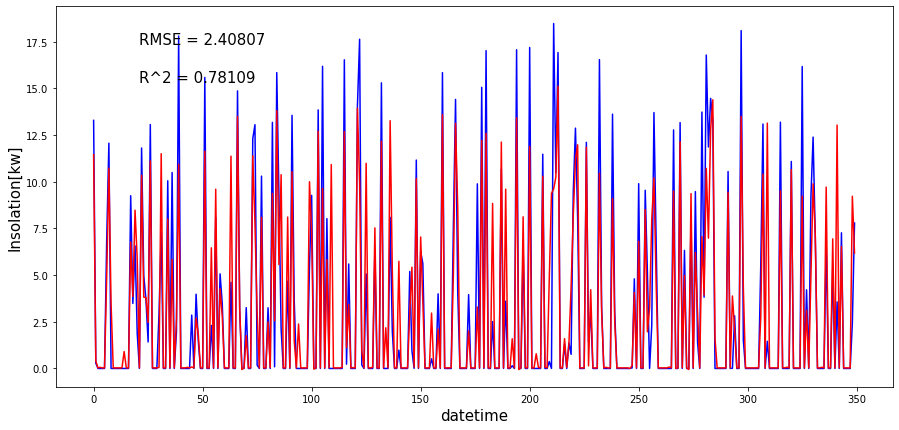

In [32]:
fig = plt.figure(figsize=(15,7))
ax = plt.subplot(111)
x = X
y1 = pred_df['actual']
y2 = pred_df['pred']
ax.set_xlabel('datetime', fontsize=15)
ax.set_ylabel('Insolation[kw]', fontsize=15)
ax.plot(x,y1,'b-')
ax.plot(x,y2,'r-')
plt.text(0.1, 0.9, 'RMSE = {}'.format(str(round(RMSE, 5))), transform=ax.transAxes, fontsize=15)
plt.text(0.1, 0.8, 'R^2 = {}'.format(str(round(R2, 5))), transform=ax.transAxes, fontsize=15)
plt.show()

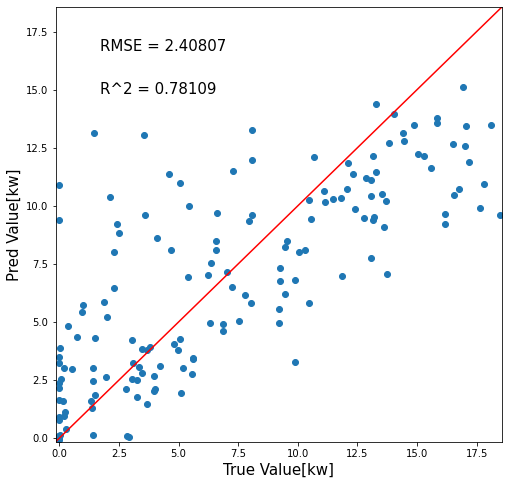

In [33]:
#R^2,RMSE
plt.figure(figsize=(8,8))
ax = plt.subplot(111)
ax.scatter('actual', 'pred', data=pred_df)
ax.set_xlabel('True Value[kw]', fontsize=15)
ax.set_ylabel('Pred Value[kw]', fontsize=15)
ax.set_xlim(pred_df.min().min()-0.1 , pred_df.max().max()+0.1)
ax.set_ylim(pred_df.min().min()-0.1 , pred_df.max().max()+0.1)
x = np.linspace(pred_df.min().min()-0.1, pred_df.max().max()+0.1, 2)
y = x
ax.plot(x,y,'r-')
plt.text(0.1, 0.9, 'RMSE = {}'.format(str(round(RMSE, 5))), transform=ax.transAxes, fontsize=15)
plt.text(0.1, 0.8, 'R^2 = {}'.format(str(round(R2, 5))), transform=ax.transAxes, fontsize=15)
plt.show()